In [1]:
import os
import sys
import gc
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import pytorch_lightning as pl
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
from sklearn.model_selection import KFold, GroupKFold

C:\Users\marcb\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
VER = 5
# IF THIS EQUALS NONE, THEN WE TRAIN NEW MODELS
# IF THIS EQUALS DISK PATH, THEN WE LOAD PREVIOUSLY TRAINED MODELS
LOAD_MODELS_FROM = None#'/kaggle/input/hms-efficientnetb0-pt-ckpts/'

USE_KAGGLE_SPECTROGRAMS = True
USE_EEG_SPECTROGRAMS = True

In [3]:
PATH_OR = "C:\\Users\\marcb\\OneDrive\\Desktop\\Kaggle_Competitions\\Kaggle-Competitions\\HMS-harmful-brain-activity\\"
test_csv = PATH_OR+'hms-harmful-brain-activity-classification/train.csv'
test_eeg = PATH_OR+'hms-harmful-brain-activity-classification/train_eegs/'
test_specs = PATH_OR+'hms-harmful-brain-activity-classification/train_spectrograms/'

df = pd.read_csv(test_csv)
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [4]:
train = df.groupby('eeg_id')[
    ['spectrogram_id', 'spectrogram_label_offset_seconds']
].agg({'spectrogram_id': 'first', 'spectrogram_label_offset_seconds': 'min'})
train.columns = ['spec_id', 'min']

tmp = df.groupby('eeg_id')[
    ['spectrogram_id','spectrogram_label_offset_seconds']
].agg({'spectrogram_label_offset_seconds' :'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1, keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [5]:
READ_SPEC_FILES = True

# READ ALL SPECTROGRAMS
PATH = test_specs
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

from joblib import Parallel, delayed
import pandas as pd

def process_file(f, PATH):
    tmp = pd.read_parquet(f'{PATH}{f}')
    name = int(f.split('.')[0])
    return name, tmp.iloc[:,1:].values

spectrograms = {}

results = Parallel(n_jobs=16)(delayed(process_file)(f, PATH) for i, f in enumerate(files))

for i, (name, spectrogram) in enumerate(results):
    if i % 100 == 0:
        print(i, ', ', end='')
    spectrograms[name] = spectrogram

# if READ_SPEC_FILES:    
#     spectrograms = {}
#     for i,f in enumerate(files):
#         if i % 100 == 0:
#             print(i, ', ', end='')
#         tmp = pd.read_parquet(f'{PATH}{f}')
#         name = int(f.split('.')[0])
#         spectrograms[name] = tmp.iloc[:,1:].values
# else:
#     spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()


There are 11138 spectrogram parquets
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 

In [6]:
from joblib.externals.loky import get_reusable_executor
get_reusable_executor().shutdown(wait=True)

In [7]:
import pywt, librosa

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]


# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)


def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret


def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    # if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
    #     if display:
    #         plt.subplot(2,2,k+1)
    #         plt.imshow(img[:,:,k],aspect='auto',origin='lower')
    #         plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    # if display: 
    #     plt.show()
    #     plt.figure(figsize=(10,5))
    #     offset = 0
    #     for k in range(4):
    #         if k>0: offset -= signals[3-k].min()
    #         plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
    #         offset += signals[3-k].max()
    #     plt.legend()
    #     plt.title(f'EEG {eeg_id} Signals')
    #     plt.show()
    #     print(); print('#'*25); print()
        
    return img

In [8]:
PATH2 = test_eeg

EEG_IDS2 = train.eeg_id.unique()

def process_eeg(eeg_id):
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet')
    return (eeg_id, img)

print('Converting Test EEG to Spectrograms...'); print()

results = Parallel(n_jobs=14)(delayed(process_eeg)(eeg_id) for eeg_id in EEG_IDS2)

all_eegs2 = dict(results)

Converting Test EEG to Spectrograms...



In [9]:
from joblib.externals.loky import get_reusable_executor
get_reusable_executor().shutdown(wait=True)

In [10]:
WEIGHTS_FILE = '/kaggle/input/hms-efficientnetb0-pt-ckpts/efficientnet_b0_rwightman-7f5810bc.pth'
import timm

class EEGEffnetB0(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        self.base_model = timm.create_model('tf_efficientnet_b3.ns_jft_in1k', in_chans=3, drop_path_rate=.2,num_classes=1000,pretrained=True)
        #self.base_model.load_state_dict(torch.load(WEIGHTS_FILE))
        self.base_model.classifier = nn.Linear(1536, 6, dtype=torch.float32)
        self.prob_out = nn.Softmax()
        
    def forward(self, x):
        x1 = [x[:, :, :, i:i+1] for i in range(4)]
        x1 = torch.concat(x1, dim=1)
        x2 = [x[:, :, :, i+4:i+5] for i in range(4)]
        x2 = torch.concat(x2, dim=1)
        
        if USE_KAGGLE_SPECTROGRAMS & USE_EEG_SPECTROGRAMS:
            x = torch.concat([x1, x2], dim=2)
        elif USE_EEG_SPECTROGRAMS:
            x = x2
        else:
            x = x1
        x = torch.concat([x, x, x], dim=3)
        x = x.permute(0, 3, 1, 2)
        
        out = self.base_model(x)
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        out = F.log_softmax(out, dim=1)
        kl_loss = nn.KLDivLoss(reduction='batchmean')
        loss = kl_loss(out, y)
        print(loss.item())
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return F.softmax(self(batch), dim=1)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [11]:
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x: y for y, x in TARS.items()}


class EEGDataset(Dataset):
    
    def __init__(self, data, augment=False, mode='train', specs=spectrograms, eeg_specs=all_eegs2): 
        self.data = data
        self.augment = augment
        self.mode = mode
        self.specs = specs
        self.eeg_specs = eeg_specs
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.__getitems__([index])
    
    def __getitems__(self, indices):
        X, y = self._generate_data(indices)
        if self.augment:
            X = self._augment(X) 
        if self.mode == 'train':
            return list(zip(X, y))
        else:
            return X
    
    def _generate_data(self, indexes):
        X = np.zeros((len(indexes), 128, 256, 8),dtype='float32')
        y = np.zeros((len(indexes), 6),dtype='float32')
        img = np.ones((128, 256),dtype='float32')
        
        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.mode == 'test': 
                r = 0
            else: 
                r = int((row['min'] + row['max'])//4)

            for k in range(4):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                img = self.specs[row.spec_id][r:r+300, k*100:(k+1)*100].T
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)
                
                # STANDARDIZE PER IMAGE
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img - m) / (s + ep)
                img = np.nan_to_num(img, nan=0.0)
                
                # CROP TO 256 TIME STEPS
                X[j, 14:-14, :, k] = img[:, 22:-22] / 2.0
        
            # EEG SPECTROGRAMS
            img = self.eeg_specs[row.eeg_id]
            X[j, :, :, 4:] = img
                
            if self.mode != 'test':
                y[j,] = row[TARGETS]
            
        return X, y
    
    def _random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            # albu.CoarseDropout(max_holes=8,max_height=32,max_width=32,fill_value=0,p=0.5),
        ])
        return composition(image=img)['image']
            
    def __augment(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i,] = self._random_transform(img_batch[i,])
        return img_batch

In [12]:
dataset = EEGDataset(train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

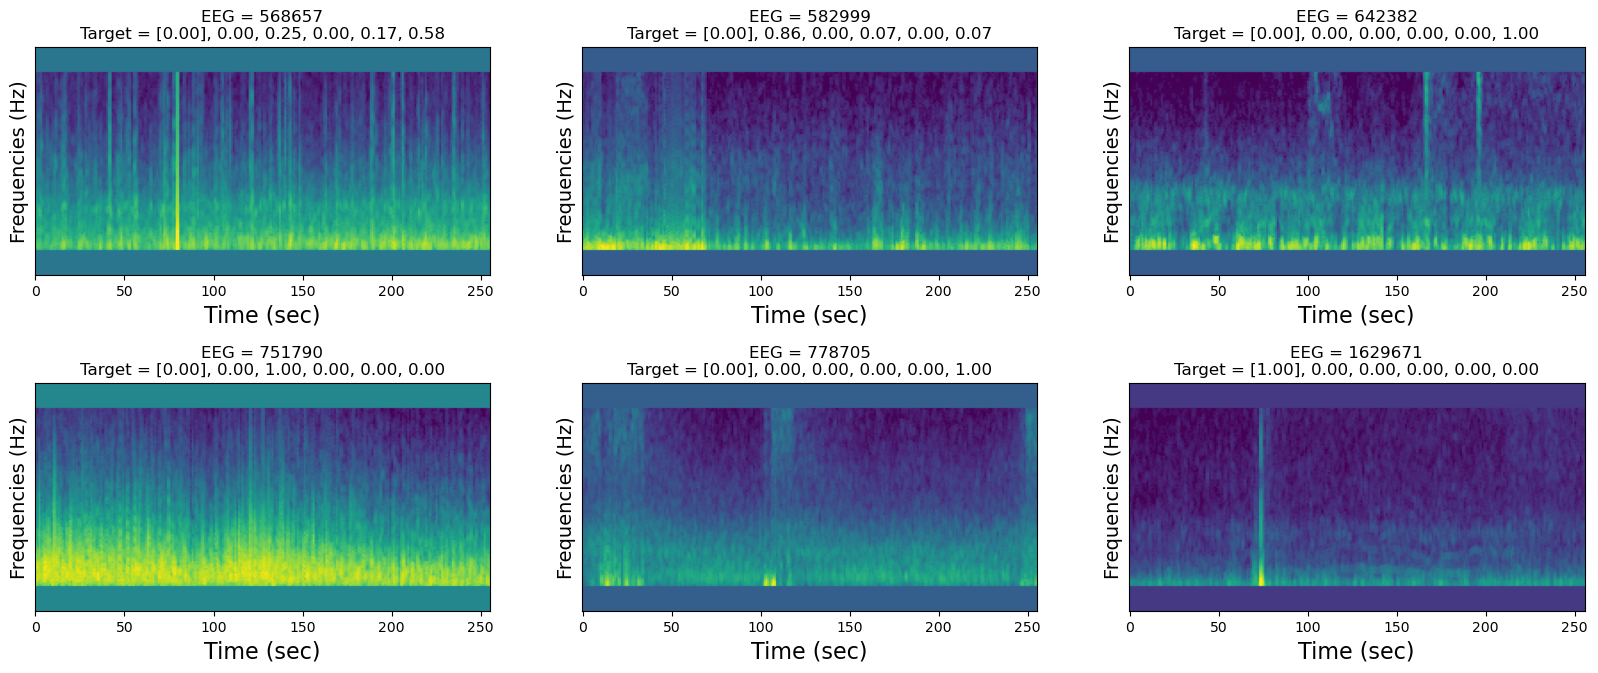

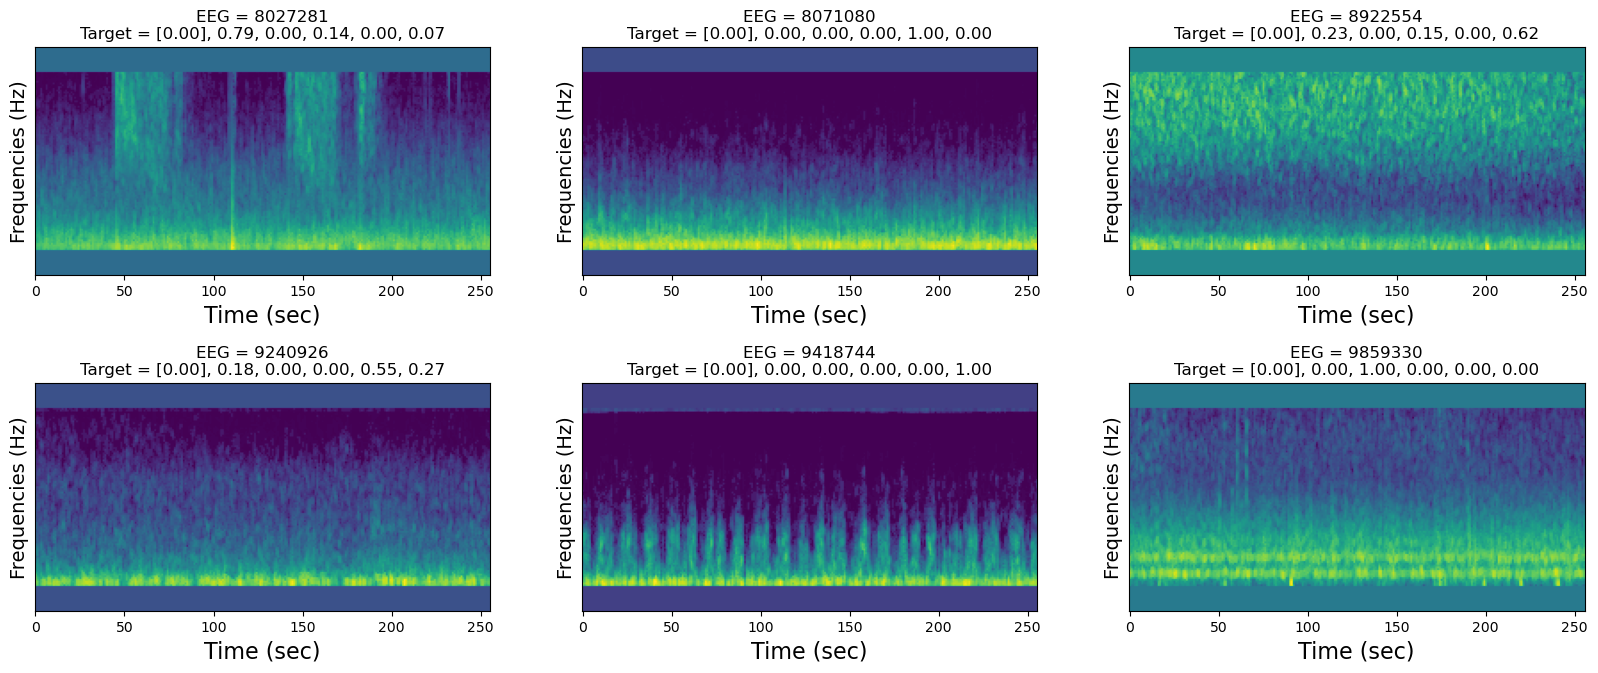

In [13]:
ROWS = 2
COLS = 3
BATCHES = 2

for i, (x, y) in enumerate(dataloader):
    plt.figure(figsize=(20, 8))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS + k + 1)
            t = y[j*COLS + k]
            img = torch.flip(x[j*COLS+k, :, :, 0], (0,))
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img-mn)/(mx-mn)
            plt.imshow(img)
            tars = f'[{t[0]:0.2f}]'
            for s in t[1:]:
                tars += f', {s:0.2f}'
            eeg = train.eeg_id.values[i*32+j*COLS+k]
            plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
            plt.yticks([])
            plt.ylabel('Frequencies (Hz)',size=14)
            plt.xlabel('Time (sec)',size=16)
    plt.show()
    if i == BATCHES-1:
        break

In [14]:
del dataset, dataloader
gc.collect()

27191

In [15]:
from pytorch_lightning.callbacks import TQDMProgressBar

progress_bar = TQDMProgressBar(
    refresh_rate=1,  # Update the progress bar every step
    process_position=0,  # Position of the progress bar
   # leave=True,  # Leave the progress bar visible after training
   # format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]",
    # Customize the format to include loss value
   # postfix={"loss": "{loss:.4f}"}  
)

In [16]:
all_oof = []
all_true = []
valid_loaders = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):  
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_ds = EEGDataset(train.iloc[train_index])
    train_loader = DataLoader(train_ds, shuffle=True, batch_size=16, num_workers=0)
    valid_ds = EEGDataset(train.iloc[valid_index], mode='valid')
    valid_loader = DataLoader(valid_ds, shuffle=False, batch_size=32, num_workers=0)
    
    print(f'### Train size: {len(train_index)}, Valid size: {len(valid_index)}')
    print('#'*25)
    
    trainer = pl.Trainer(max_epochs=4)
    model = EEGEffnetB0()
    if LOAD_MODELS_FROM is None:
        trainer.fit(model=model, train_dataloaders=train_loader)
        trainer.save_checkpoint(f'EffNet_v{VER}_f{i}.ckpt')

    valid_loaders.append(valid_loader)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    del trainer, model
    torch.cuda.empty_cache()
    gc.collect()

#########################
### Fold 1
### Train size: 13671, Valid size: 3418
#########################


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\marcb\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precisi

Training: |                                              | 0/? [00:00<?, ?it/s]

1.307055115699768
1.4069631099700928
1.4184856414794922
1.5215175151824951
1.2084414958953857
0.9844099283218384
1.529343605041504
1.0659968852996826
1.1252872943878174
1.3484247922897339
1.0593942403793335
0.9738659858703613
1.098499059677124
0.9232925772666931
1.3456346988677979
0.7576302886009216
1.5048766136169434
1.3486955165863037
1.2198784351348877
1.0295827388763428
0.8456178307533264
1.1766819953918457
0.8633130788803101
1.1030280590057373
0.6651039719581604
0.7031879425048828
0.9327078461647034
0.6877517104148865
0.9546233415603638
1.1638602018356323
0.9470090866088867
0.6384387016296387
0.9828662276268005
0.8037533760070801
0.6828621625900269
1.0740758180618286
0.7975126504898071
0.7656819820404053
1.078719139099121
0.7001582384109497
0.9969208240509033
1.3339463472366333
0.7308037281036377
1.0289268493652344
1.3463857173919678
0.9609980583190918
0.9612393379211426
0.8222576379776001
1.064774513244629
1.009773850440979
1.0732319355010986
0.9713255167007446
0.8113515377044678

`Trainer.fit` stopped: `max_epochs=4` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#########################
### Fold 2
### Train size: 13671, Valid size: 3418
#########################


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type         | Params
--------------------------------------------
0 | base_model | EfficientNet | 10.7 M
1 | prob_out   | Softmax      | 0     
--------------------------------------------
10.7 M    Trainable params
0         Non-trainable params
10.7 M    Total params
42.822    Total estimated model params size (MB)


Training: |                                              | 0/? [00:00<?, ?it/s]

1.4443163871765137
1.5593371391296387
1.2435407638549805
1.324270486831665
1.1587049961090088
1.5486526489257812
1.1524004936218262
1.1143254041671753
1.352123737335205
1.2552987337112427
0.9255675673484802
1.0883172750473022
1.0482244491577148
1.056800365447998
1.167217493057251
0.9513255953788757
0.9858955144882202
0.7568037509918213
1.0726408958435059
1.0737403631210327
1.1363134384155273
1.064803123474121
1.1872341632843018
0.7737545967102051
1.0460388660430908
1.0897060632705688
1.4966657161712646
0.8972833752632141
1.117652416229248
0.7482031583786011
1.294490098953247
0.9419333934783936
1.0513960123062134
0.8180176019668579
1.2587261199951172
1.1945418119430542
1.1266522407531738
0.8748499155044556
1.011684536933899
0.915553092956543
1.1936204433441162
0.8667380809783936
1.3749139308929443
1.1404640674591064
0.9957417845726013
0.8820959329605103
1.1053249835968018
1.0196571350097656
0.7438637614250183
0.8644830584526062
1.337010145187378
1.0201743841171265
1.0828030109405518
1.3

`Trainer.fit` stopped: `max_epochs=4` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#########################
### Fold 3
### Train size: 13671, Valid size: 3418
#########################


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type         | Params
--------------------------------------------
0 | base_model | EfficientNet | 10.7 M
1 | prob_out   | Softmax      | 0     
--------------------------------------------
10.7 M    Trainable params
0         Non-trainable params
10.7 M    Total params
42.822    Total estimated model params size (MB)


Training: |                                              | 0/? [00:00<?, ?it/s]

1.5225765705108643
1.4791702032089233
1.4035136699676514
1.2875490188598633
1.1102843284606934
1.4309031963348389
1.574357032775879
1.5082614421844482
1.174115777015686
1.2572574615478516
1.316296100616455
1.080928087234497
1.3430707454681396
1.0998680591583252
1.0285347700119019
0.9120618104934692
0.9169056415557861
1.0074796676635742
1.4329880475997925
0.8497992753982544
0.8871999382972717
0.8964519500732422
1.2472546100616455
0.8914650082588196
0.7248449325561523
1.137362003326416
1.0551563501358032
1.008868932723999
1.2244513034820557
0.9674332141876221
1.1891593933105469
0.9206528663635254
0.7561357617378235
0.9395155906677246
0.8586428165435791
1.4592957496643066
0.8237709999084473
1.2055296897888184
1.1850849390029907
0.9708967804908752
1.4367101192474365
1.1207941770553589
0.8784345984458923
1.213767409324646
1.0313220024108887
0.9748319983482361
1.049772024154663
1.1101024150848389
0.8632184267044067
0.6799283027648926
1.0343317985534668
0.9318498373031616
0.9909121990203857
1

`Trainer.fit` stopped: `max_epochs=4` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#########################
### Fold 4
### Train size: 13671, Valid size: 3418
#########################


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type         | Params
--------------------------------------------
0 | base_model | EfficientNet | 10.7 M
1 | prob_out   | Softmax      | 0     
--------------------------------------------
10.7 M    Trainable params
0         Non-trainable params
10.7 M    Total params
42.822    Total estimated model params size (MB)


Training: |                                              | 0/? [00:00<?, ?it/s]

1.2726420164108276
1.299073576927185
1.3701374530792236
1.1319438219070435
1.2359718084335327
1.1966242790222168
1.3813267946243286
0.8165719509124756
1.0532416105270386
1.4329612255096436
1.038614273071289
1.2571446895599365
1.1712535619735718
1.039791464805603
1.0005569458007812
1.1765481233596802
1.2176947593688965
1.1382566690444946
1.1406548023223877
0.8523837327957153
0.9312723278999329
1.2406198978424072
1.0393540859222412
1.296633005142212
1.3523049354553223
1.0170719623565674
1.043942928314209
1.1358842849731445
1.274622917175293
0.9879529476165771
0.7821639180183411
0.8132050633430481
0.8616059422492981
1.080960988998413
1.4466509819030762
1.038710117340088
0.9004718661308289
0.9681762456893921
0.842792272567749
1.0576552152633667
0.8110592365264893
1.10515296459198
1.428480625152588
0.7937229871749878
0.9867271780967712
1.050124168395996
0.9821169376373291
0.7750152945518494
1.2365185022354126
0.9651594758033752
0.9282889366149902
0.9129968881607056
1.052085041999817
0.65700

`Trainer.fit` stopped: `max_epochs=4` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#########################
### Fold 5
### Train size: 13672, Valid size: 3417
#########################


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type         | Params
--------------------------------------------
0 | base_model | EfficientNet | 10.7 M
1 | prob_out   | Softmax      | 0     
--------------------------------------------
10.7 M    Trainable params
0         Non-trainable params
10.7 M    Total params
42.822    Total estimated model params size (MB)


Training: |                                              | 0/? [00:00<?, ?it/s]

1.5463422536849976
1.4774720668792725
1.2663755416870117
1.133167028427124
1.23177170753479
1.042008399963379
1.2846136093139648
1.234703540802002
0.9952039122581482
1.1679682731628418
0.9993988275527954
0.7659397721290588
0.9208285808563232
1.319657802581787
1.6841236352920532
1.085634708404541
0.9713951945304871
0.9306106567382812
1.0719432830810547
1.0199745893478394
0.8333927392959595
1.0121054649353027
1.0136733055114746
0.9139674305915833
1.0349318981170654
0.7536115646362305
0.9070468544960022
1.2708303928375244
0.8959454298019409
0.7426717877388
0.817092776298523
1.3816766738891602
1.1060948371887207
0.8003455996513367
1.5344321727752686
0.9253451228141785
1.0526741743087769
0.8978314399719238
0.8573902249336243
1.2459129095077515
0.862281084060669
0.8693423271179199
1.067223310470581
1.3851975202560425
0.8728617429733276
0.6205063462257385
0.9186910390853882
0.9434094429016113
0.7352908253669739
0.9830308556556702
0.9490001797676086
0.8644801378250122
0.8782182931900024
0.9564

`Trainer.fit` stopped: `max_epochs=4` reached.


In [17]:
del model
torch.cuda.empty_cache()
gc.collect()

NameError: name 'model' is not defined

In [19]:
device='cuda'
for i in range(5):
    print('#'*25)
    print(f'### Validating Fold {i+1}')

    ckpt_file = f'EffNet_v{VER}_f{i}.ckpt' if LOAD_MODELS_FROM is None else f'{LOAD_MODELS_FROM}/EffNet_v{VER}_f{i}.ckpt'
    model = EEGEffnetB0.load_from_checkpoint(ckpt_file)
    model.to(device).eval()
    with torch.inference_mode():
        for val_batch in valid_loaders[i]:
            val_batch = val_batch.to(device)
            oof = torch.softmax(model(val_batch), dim=1).cpu().numpy()
            all_oof.append(oof)
    del model
    gc.collect()

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Validating Fold 1
#########################
### Validating Fold 2
#########################
### Validating Fold 3
#########################
### Validating Fold 4
#########################
### Validating Fold 5


In [20]:
oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for EfficientNetB2 =',cv)

CV Score KL-Div for EfficientNetB2 = 0.6287533002910144


In [ ]:
# INFER EFFICIENTNET ON TEST
preds = []
test_ds = EEGDataset(test, mode='test', specs=spectrograms2, eeg_specs=all_eegs2)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=64, num_workers=3)

for i in range(5):
    print('#'*25)
    print(f'### Testing Fold {i+1}')

    ckpt_file = f'EffNet_v{VER}_f{i}.ckpt' if LOAD_MODELS_FROM is None else f'{LOAD_MODELS_FROM}/EffNet_v{VER}_f{i}.ckpt'
    model = EEGEffnetB0.load_from_checkpoint(ckpt_file)
    model.to(device).eval()
    fold_preds = []

    with torch.inference_mode():
        for test_batch in test_loader:
            test_batch = test_batch.to(device)
            pred = torch.softmax(model(test_batch), dim=1).cpu().numpy()
            fold_preds.append(pred)
        fold_preds = np.concatenate(fold_preds)

    preds.append(fold_preds)

pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

In [ ]:
sub = pd.DataFrame({'eeg_id': test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submissionn shape',sub.shape)
sub.head()

In [ ]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)